In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from time import time

In [2]:
df1 = pd.read_csv('../data/match_data.csv')
X1 = df1.drop(columns=['Date', 'Team1', 'Team2', 'Score'])
y1 = df1['Score']
ds1_name = "match_data"
best_lr1 = 0.001
best_dropout1 = 0.5
best_l2_reg1 = 0.0001
best_batch_size1 = 64
best_epochs1 = 500

df2 = pd.read_csv('../data/cleaned_rounds_data.csv')
df2 = df2.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X2 = df2.drop(['round_winner'], axis=1)
y2 = df2['round_winner']
ds2_name = "rounds_data"
best_lr2 = 0.0005
best_dropout2 = 0.3
best_l2_reg2 = 0.001
best_batch_size2 = 64
best_epochs2 = 1000

df3 = pd.read_csv('../data/cleaned_rounds_data_with_stats.csv')
df3 = df3.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X3 = df3.drop(['round_winner'], axis=1)
y3 = df3['round_winner']
ds3_name = "rounds_data_with_stats"
best_lr3 = 0.0001
best_dropout3 = 0.3
best_l2_reg3 = 0.01
best_batch_size3 = 128
best_epochs3 = 300

datasets = [(X1, y1, ds1_name, best_lr1, best_dropout1, best_l2_reg1, best_batch_size1, best_epochs1),
            (X2, y2, ds2_name, best_lr2, best_dropout2, best_l2_reg2, best_batch_size2, best_epochs2),
            (X3, y3, ds3_name, best_lr3, best_dropout3, best_l2_reg3, best_batch_size3, best_epochs3)]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Dataset: match_data with best_lr=0.001, best_dropout=0.5, best_l2_reg=0.0001, best_batch_size=64, best_epochs=500
Time to fit and predict: 4.8147711753845215 seconds
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       252
           1       0.62      0.63      0.62       259

    accuracy                           0.62       511
   macro avg       0.62      0.62      0.62       511
weighted avg       0.62      0.62      0.62       511

                 Predicted Negative  Predicted Positive
Actual Negative                 153                  99
Actual Positive                  97                 162
ROC AUC: 0.6604997854997855
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
Dataset: rounds_data with best_lr=0.0005, best_dropout=0.3, best_l2_reg=0.001, best_batch_size=64, best_epochs=1000
Time to fit and predict: 7.076531648635864 seconds
              precision    recall  f1-score   support

        

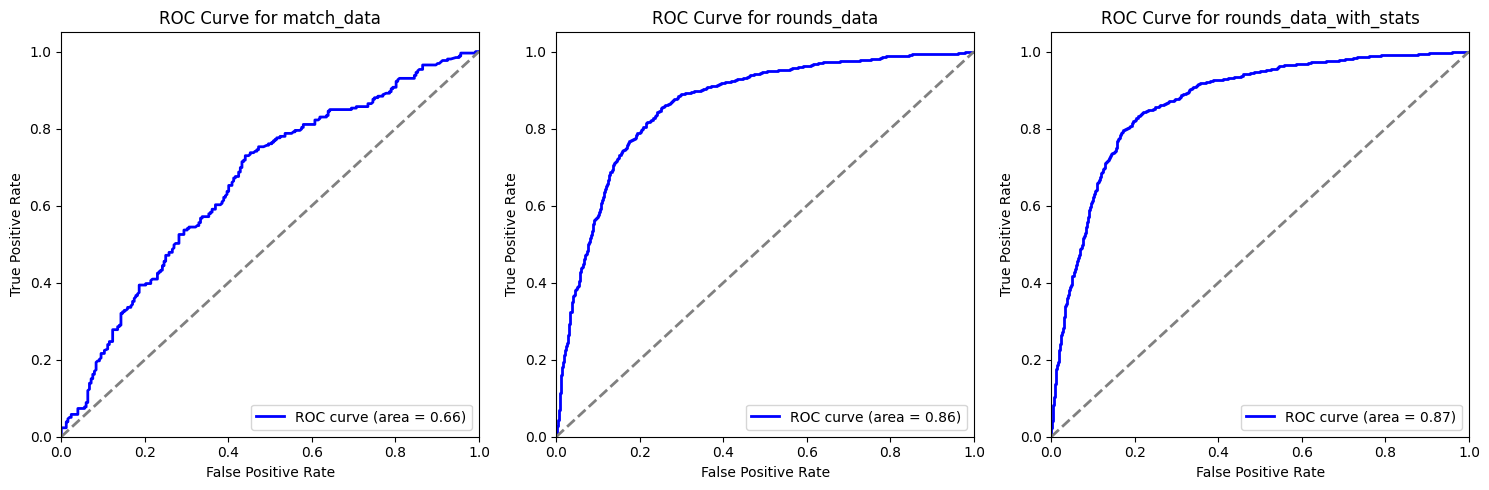

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx, (X, y, ds_name, best_lr, best_dropout, best_l2_reg, best_batch_size, best_epochs) in enumerate(datasets):
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(best_l2_reg)))
    model.add(Dropout(best_dropout))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(best_l2_reg)))
    model.add(Dropout(best_dropout))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(best_l2_reg)))
    model.add(Dropout(best_dropout))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=best_lr)

    start_time = time()

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=best_batch_size, epochs=best_epochs, callbacks=[es], verbose=0)

    y_probs = model.predict(X_test)
    y_pred = (y_probs > 0.5).astype(int)

    print(f"Dataset: {ds_name} with best_lr={best_lr}, best_dropout={best_dropout}, best_l2_reg={best_l2_reg}, best_batch_size={best_batch_size}, best_epochs={best_epochs}")
    print(f"Time to fit and predict: {time() - start_time} seconds")
    
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])
    print(conf_matrix_df)
    print(f"ROC AUC: {roc_auc_score(y_test, y_probs)}")
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    
    axs[idx].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_probs):.2f})')
    axs[idx].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    axs[idx].set_xlim([0.0, 1.0])
    axs[idx].set_ylim([0.0, 1.05])
    axs[idx].set_xlabel('False Positive Rate')
    axs[idx].set_ylabel('True Positive Rate')
    axs[idx].set_title(f'ROC Curve for {ds_name}')
    axs[idx].legend(loc='lower right')

plt.tight_layout()
plt.show()